In [2]:
#import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [3]:
sfincs_root = "sfincs_update_bangkok_wg_historic_1_design_event_rp100"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

In [4]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()
# the following variables have been found
list(mod.results.keys())

['inp',
 'msk',
 'qinf',
 'zb',
 'zs',
 'h',
 'zsmax',
 'hmax',
 'cuminf',
 'total_runtime',
 'average_dt',
 'point_zb',
 'point_zs',
 'point_h',
 'point_u',
 'point_v',
 'point_qinf']

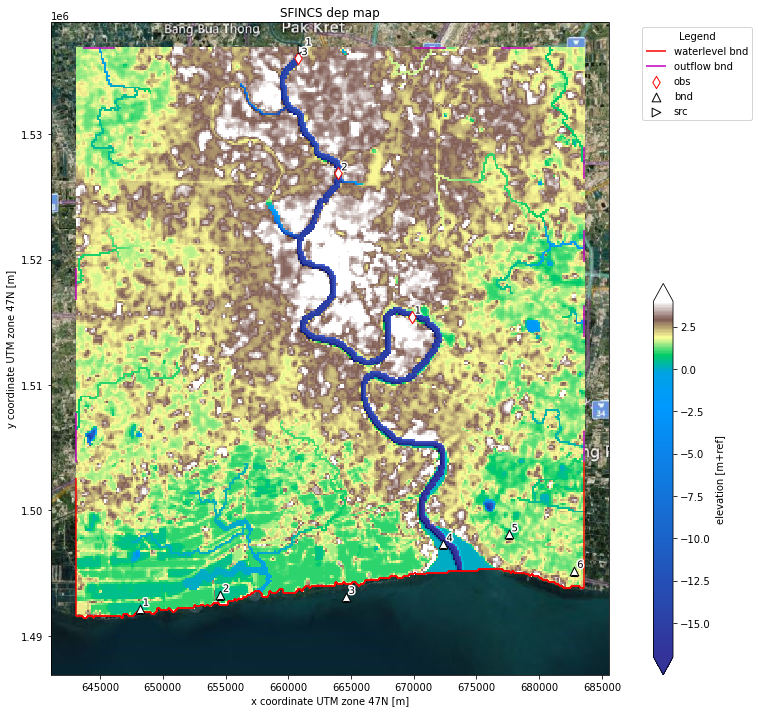

In [5]:
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(16, 12))

In [6]:
# write hmax to <mod.root>/gis/hmax.tif
mod.write_raster("results.hmax", compress="LZW")

# this is identical to the following:
# hmax = mod.results['hmax']
# hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
# hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

In [7]:
# read global surface water occurance (GSWO) data to mask permanent water
# NOTE to read data for a different region than Northen Italy add this data to the data catalog:
# mod.data_catalog.from_yml("./examples/test_barcelona_sfincs_150/data_catalog")
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 5

data_type: RasterDataset
driver: raster
kwargs:
  chunks:
    x: 4000
    y: 4000
meta:
  category: hydrography
  paper_doi: 10.1038/nature20584
  paper_ref: Pekel et al. (2016)
  source_url: https://global-surface-water.appspot.com/download
  source_version: v1_1_2019
nodata: 255
path: p:\wflow_global\hydromt\hydrography\gswo\occur.vrt



nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


In [8]:
hmin = 0.2  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

Text(0.5, 1.0, 'SFINCS maximum water depth')

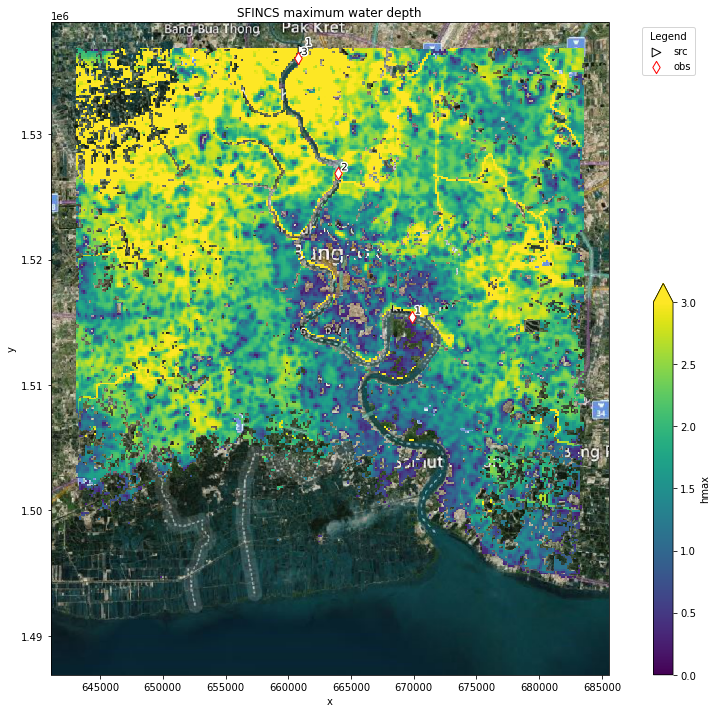

In [9]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>],
       dtype=object))

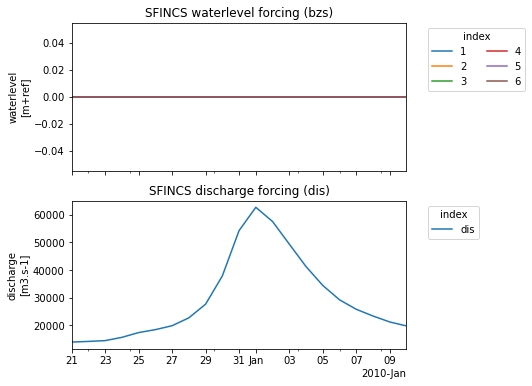

In [10]:
mod.plot_forcing()